In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
import os
import re
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision.transforms import Normalize
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from skimage.filters import threshold_otsu
from torchvision.transforms.functional import to_pil_image

In [2]:
# Set the device for computation (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 64 * 64, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)  # Updated output size
        self.leaky_relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.pool(self.leaky_relu(self.conv1(x)))
        x = self.pool(self.leaky_relu(self.conv2(x)))
        x = self.pool(self.leaky_relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x.view(-1)


In [36]:
transform = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(512),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.4753, 0.4753, 0.4753])
])

Epoch 1 - Training Loss: 1864.151666 - Validation Loss: 557.065441 - Learning Rate: 0.001
Epoch 1 completed.
Epoch 2 - Training Loss: 875.883875 - Validation Loss: 284.029291 - Learning Rate: 0.001
Epoch 2 completed.
Epoch 3 - Training Loss: 681.374615 - Validation Loss: 226.134946 - Learning Rate: 0.001
Epoch 3 completed.
Epoch 4 - Training Loss: 544.766922 - Validation Loss: 248.146969 - Learning Rate: 0.001
Epoch 4 completed.
Epoch 5 - Training Loss: 468.513943 - Validation Loss: 203.304196 - Learning Rate: 0.001
Epoch 5 completed.
Epoch 6 - Training Loss: 410.588229 - Validation Loss: 207.466240 - Learning Rate: 0.001
Epoch 6 completed.
Epoch 7 - Training Loss: 397.700711 - Validation Loss: 201.909314 - Learning Rate: 0.001
Epoch 7 completed.
Epoch 8 - Training Loss: 451.347940 - Validation Loss: 195.813242 - Learning Rate: 0.001
Epoch 8 completed.
Epoch 9 - Training Loss: 393.707486 - Validation Loss: 189.114464 - Learning Rate: 0.001
Epoch 9 completed.
Epoch 10 - Training Loss: 3

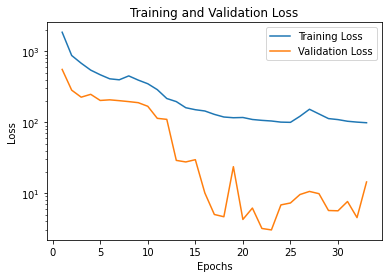

Accuracy for Train_510: 11.86%
Epoch 1 - Training Loss: 1432.834396 - Validation Loss: 300.700934 - Learning Rate: 0.001
Epoch 1 completed.
Epoch 2 - Training Loss: 619.055807 - Validation Loss: 215.199750 - Learning Rate: 0.001
Epoch 2 completed.
Epoch 3 - Training Loss: 442.224960 - Validation Loss: 211.371201 - Learning Rate: 0.001
Epoch 3 completed.
Epoch 4 - Training Loss: 341.510577 - Validation Loss: 104.857429 - Learning Rate: 0.001
Epoch 4 completed.
Epoch 5 - Training Loss: 228.504832 - Validation Loss: 32.181935 - Learning Rate: 0.001
Epoch 5 completed.
Epoch 6 - Training Loss: 165.006946 - Validation Loss: 16.304829 - Learning Rate: 0.001
Epoch 6 completed.
Epoch 7 - Training Loss: 148.978830 - Validation Loss: 93.944644 - Learning Rate: 0.001
Epoch 7 completed.
Epoch 8 - Training Loss: 175.944933 - Validation Loss: 14.104687 - Learning Rate: 0.001
Epoch 8 completed.
Epoch 9 - Training Loss: 133.343483 - Validation Loss: 12.845368 - Learning Rate: 0.001
Epoch 9 completed.
E

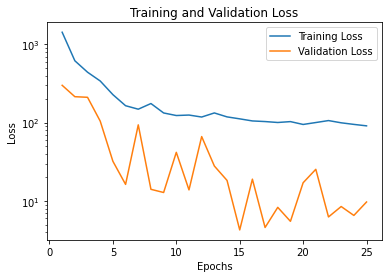

Accuracy for Train_1020: 27.87%
Epoch 1 - Training Loss: 1000.207738 - Validation Loss: 220.254188 - Learning Rate: 0.001
Epoch 1 completed.
Epoch 2 - Training Loss: 418.274651 - Validation Loss: 179.989238 - Learning Rate: 0.001
Epoch 2 completed.
Epoch 3 - Training Loss: 233.804767 - Validation Loss: 12.657530 - Learning Rate: 0.001
Epoch 3 completed.
Epoch 4 - Training Loss: 136.661453 - Validation Loss: 7.059929 - Learning Rate: 0.001
Epoch 4 completed.
Epoch 5 - Training Loss: 116.336111 - Validation Loss: 3.730152 - Learning Rate: 0.001
Epoch 5 completed.
Epoch 6 - Training Loss: 118.949120 - Validation Loss: 5.016385 - Learning Rate: 0.001
Epoch 6 completed.
Epoch 7 - Training Loss: 103.332166 - Validation Loss: 5.877728 - Learning Rate: 0.001
Epoch 7 completed.
Epoch 8 - Training Loss: 100.936934 - Validation Loss: 7.009731 - Learning Rate: 0.001
Epoch 8 completed.
Epoch 9 - Training Loss: 99.177803 - Validation Loss: 5.131002 - Learning Rate: 0.001
Epoch 9 completed.
Epoch 10 

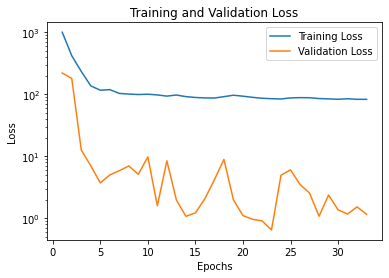

Accuracy for Train_2040: 62.00%
Epoch 1 - Training Loss: 633.625415 - Validation Loss: 77.128396 - Learning Rate: 0.001
Epoch 1 completed.
Epoch 2 - Training Loss: 158.381110 - Validation Loss: 11.768194 - Learning Rate: 0.001
Epoch 2 completed.
Epoch 3 - Training Loss: 122.573744 - Validation Loss: 7.033016 - Learning Rate: 0.001
Epoch 3 completed.
Epoch 4 - Training Loss: 119.230766 - Validation Loss: 3.413976 - Learning Rate: 0.001
Epoch 4 completed.
Epoch 5 - Training Loss: 102.236234 - Validation Loss: 8.554366 - Learning Rate: 0.001
Epoch 5 completed.
Epoch 6 - Training Loss: 97.394829 - Validation Loss: 1.513172 - Learning Rate: 0.001
Epoch 6 completed.
Epoch 7 - Training Loss: 92.495315 - Validation Loss: 1.045049 - Learning Rate: 0.001
Epoch 7 completed.
Epoch 8 - Training Loss: 92.744630 - Validation Loss: 3.288500 - Learning Rate: 0.001
Epoch 8 completed.
Epoch 9 - Training Loss: 88.667682 - Validation Loss: 2.246256 - Learning Rate: 0.001
Epoch 9 completed.
Epoch 10 - Train

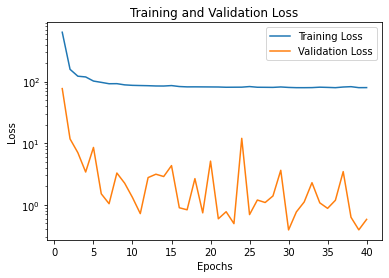

Accuracy for Train_4080: 60.62%
[1,   100] loss: 602.096857
Epoch 1 - Training Loss: 59.259552 - Validation Loss: 24.602948 - Learning Rate: 0.001
Epoch 1 completed.
[2,   100] loss: 125.446717
Epoch 2 - Training Loss: 39.488937 - Validation Loss: 4.836759 - Learning Rate: 0.001
Epoch 2 completed.
[3,   100] loss: 102.157234
Epoch 3 - Training Loss: 32.665201 - Validation Loss: 6.836018 - Learning Rate: 0.001
Epoch 3 completed.
[4,   100] loss: 98.539896
Epoch 4 - Training Loss: 34.433743 - Validation Loss: 2.310849 - Learning Rate: 0.001
Epoch 4 completed.
[5,   100] loss: 90.686993
Epoch 5 - Training Loss: 30.463824 - Validation Loss: 2.111718 - Learning Rate: 0.001
Epoch 5 completed.
[6,   100] loss: 86.751347
Epoch 6 - Training Loss: 30.132205 - Validation Loss: 1.539215 - Learning Rate: 0.001
Epoch 6 completed.
[7,   100] loss: 86.191833
Epoch 7 - Training Loss: 29.563133 - Validation Loss: 1.092698 - Learning Rate: 0.001
Epoch 7 completed.
[8,   100] loss: 85.968318
Epoch 8 - Tra

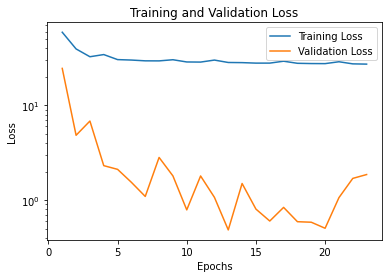

Accuracy for Train_8160: 56.57%
[1,   100] loss: 516.980189
Epoch 1 - Training Loss: 64.398686 - Validation Loss: 4.914063 - Learning Rate: 0.001
Epoch 1 completed.
[2,   100] loss: 115.922502
Epoch 2 - Training Loss: 50.831776 - Validation Loss: 4.317931 - Learning Rate: 0.001
Epoch 2 completed.
[3,   100] loss: 96.038176
Epoch 3 - Training Loss: 45.894415 - Validation Loss: 2.894196 - Learning Rate: 0.001
Epoch 3 completed.
[4,   100] loss: 91.119189
Epoch 4 - Training Loss: 42.044717 - Validation Loss: 1.433026 - Learning Rate: 0.001
Epoch 4 completed.
[5,   100] loss: 89.102405
Epoch 5 - Training Loss: 41.151656 - Validation Loss: 2.504532 - Learning Rate: 0.001
Epoch 5 completed.
[6,   100] loss: 85.282095
Epoch 6 - Training Loss: 40.992652 - Validation Loss: 1.867909 - Learning Rate: 0.001
Epoch 6 completed.
[7,   100] loss: 84.103060
Epoch 7 - Training Loss: 39.912729 - Validation Loss: 0.619614 - Learning Rate: 0.001
Epoch 7 completed.
[8,   100] loss: 83.402640
Epoch 8 - Train

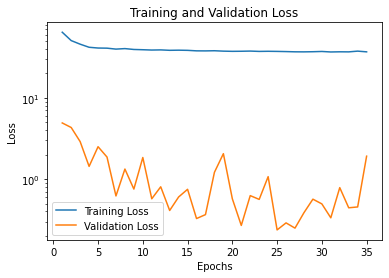

Accuracy for Train_10200: 77.74%


In [37]:
# Create training dataset
# Set up the data directories
sets = ['Train_510', 'Train_1020', 'Train_2040', 'Train_4080', 'Train_8160', 'Train_10200']
best_train_losses = {}  # Dictionary to store the best training loss for each item
best_val_losses = {}  # Dictionary to store the best validation loss for each item
accuracy = []

for item in sets:
    data_dir = 'Test_Images'
    train_dir = os.path.join(data_dir, item)

    # Define a function to get the labels from the image filenames
    def get_label(filename):
        match = re.search(r'\d+\.?\d*', filename)
        if match:
            return float(match.group())
        else:
            return None

    # Define a list to store the image filenames and labels
    train_data = []

    # Iterate over the training images and add them to the list
    for filename in os.listdir(train_dir):
        label = get_label(filename)
        if label is not None:
            train_data.append([os.path.join(train_dir, filename), label])

    # Convert the list to a dataframe
    train_df = pd.DataFrame(train_data, columns=['filename', 'label'])

    # Save the dataframe to a CSV file
    train_df.to_csv(os.path.join(data_dir, item+'.csv'), index=False)

class CustomImageDataset(Dataset):
    def __init__(self, csv_file, image_folder, transform=None):
        self.data = self._load_data(csv_file)
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_path, label = self.data[index]
        image = Image.open(image_path).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def _load_data(self, csv_file):
        data = []
        with open(csv_file, 'r') as file:
            lines = file.readlines()
            for line in lines[1:]:
                image_path, label = line.strip().split(',')
                data.append((image_path, float(label)))
        return data



for item in sets:
    csv_file = f'Test_Images/{item}.csv'
    image_folder = f'Test_Images/{item}'

    dataset = CustomImageDataset(csv_file, image_folder, transform=transform)

    train_size = int(0.6 * len(dataset))
    val_size = int(0.2 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

    num_epochs = 50
    best_val_loss = float('inf')
    best_learning_rate = None
    patience = 10
    counter = 0
    learning_rate = 0.001
    
    train_losses = []
    val_losses = []
    epoch_numbers = []
    item_train_losses = []  # List to store training losses for the current item
    item_val_losses = []  # List to store validation losses for the current item

    model = CNN().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    threshold=0.5
    
    for epoch in range(num_epochs):
        running_loss = 0.0

        model.train()
        for i, (inputs, labels) in enumerate(train_loader, 0):
            optimizer.zero_grad()
            inputs = inputs.to(device)  # Move inputs to the device
            labels = labels.to(device)  # Move labels to the device

             # Binarize inputs
            threshold = 0.5
            inputs = torch.where(inputs >= threshold, torch.ones_like(inputs), torch.zeros_like(inputs))
            inputs = inputs[:, :1, :, :]

            outputs = model(inputs)
            labels = labels.float()
            loss = criterion(outputs, labels)

            l1_lambda = 0.01
            l1_regularization = torch.tensor(0.).to(device)
            for param in model.parameters():
                l1_regularization += torch.norm(param, 1).to(device)
            loss += l1_lambda * l1_regularization

            l2_lambda = 0.01
            l2_regularization = torch.tensor(0.).to(device)
            for param in model.parameters():
                l2_regularization += torch.norm(param, 2).to(device)
            loss += l2_lambda * l2_regularization

            running_loss += loss.item()

            loss.backward()
            optimizer.step()

            if i % 100 == 99:
                print('[%d, %5d] loss: %.6f' % (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0

        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            val_samples = 0
            for inputs, labels in val_loader:
                inputs = inputs.to(device)  # Move inputs to the device
                labels = labels.to(device)  # Move labels to the device

                # Binarize inputs
                threshold = 0.5
                inputs = torch.where(inputs >= threshold, torch.ones_like(inputs), torch.zeros_like(inputs))
                inputs = inputs[:, :1, :, :]
                
                outputs = model(inputs)
                labels = labels.float()
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_samples += inputs.size(0)

            average_val_loss = val_loss / val_samples

            train_losses.append(running_loss / len(train_loader))
            val_losses.append(average_val_loss)
            item_train_losses.append(running_loss / len(train_loader))
            item_val_losses.append(average_val_loss)

            epoch_numbers.append(epoch + 1)
            print('Epoch %d - Training Loss: %.6f - Validation Loss: %.6f - Learning Rate: %.3f' % (epoch + 1, running_loss / len(train_loader), average_val_loss, learning_rate))

        if average_val_loss < best_val_loss:
            best_val_loss = average_val_loss
            counter = 0
            torch.save(model.state_dict(), f'trained_model_{item}_simple.pt')

        else:
            counter += 1
            if counter >= patience:
                print('No improvement in validation loss. Early stopping.')
                break

        print('Epoch %d completed.' % (epoch + 1))

    best_train_loss = min(item_train_losses)
    best_train_losses[item] = best_train_loss

    best_val_loss = min(item_val_losses)
    best_val_losses[item] = best_val_loss
    
    # Plotting the losses
    plt.plot(epoch_numbers, train_losses, label='Training Loss')
    plt.plot(epoch_numbers, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig(f'loss_plot_{item}_simple.jpeg', format='jpeg')
    plt.show()
    
    # Create a DataFrame to store the predictions
    predictions_test_df = pd.DataFrame(columns=['Real Value', 'Predicted Value', 'Difference'])

    model = CNN().to(device)  # Instantiate a new instance of the CNN class to CUDA cores (if available)
    model.load_state_dict(torch.load(f'trained_model_{item}_simple.pt'))  # Load the state dictionary of the pre-trained model

    # Set the model to evaluation mode
    model.eval()

    # Initialize variables for tracking correct predictions and total samples
    correct_predictions = 0
    total_samples = 0

    # Define the range for considering a prediction as correct
    max_range = 0.5

    # Iterate over the test data
    for sample in test_loader:
            

        # Move the input data to the device
        inputs = sample[0].to(device)  # The input images are the first element in each sample
        inputs = torch.where(inputs >= threshold, torch.ones_like(inputs), torch.zeros_like(inputs))
        inputs = inputs[:, :1, :, :]    
        labels = sample[1].to(device)  # The labels are the second element in each sample

        # Forward pass through the model
        with torch.no_grad():
            predicted_values = model(inputs).tolist()

        # Get the predicted labels
        predicted_labels = outputs  # Assuming the model output is a single scalar value

        
    # Iterate over the predicted values and add them to the DataFrame
        for i in range(len(labels)):
            real_value = labels[i].item()
            predicted_value = predicted_values[i]

            # Check if the predicted value is within the desired range (40-70)
            if real_value >= 40 and real_value <= 70:
                # Calculate the difference between predicted and real value
                difference = predicted_value - real_value

                # Create a new DataFrame with the row to be appended
                new_row = pd.DataFrame({'Real Value': real_value, 'Predicted Value': predicted_value, 'Difference': difference}, index=[0])

                # Concatenate the new row with the existing DataFrame
                predictions_test_df = pd.concat([predictions_test_df, new_row], ignore_index=True)

                # Check if the prediction is correct within the desired range
                if abs(real_value - predicted_value) <= max_range:
                    correct_predictions += 1


    # Calculate the accuracy
    accuracy_value = correct_predictions / (len(predictions_test_df)-1)
    accuracy.append(accuracy_value)

    # Print the accuracy
    print(f"Accuracy for {item}: {accuracy_value * 100:.2f}%")

In [38]:
# Print best losses of all epochs and print accuracy of trained model
for i, item in enumerate(sets):
    print(f"Item: {item}")                                      # Print which dataset is used
    print(f"Best Validation Loss: {best_val_losses[item]}")     # Print best validation loss
    print(f"Best Training Loss: {best_train_losses[item]}")     # Print best training loss
    print(f"Accuracy for {item}: {accuracy[i] * 100:.2f}%")     # Print accuracy trained model

Item: Train_510
Best Validation Loss: 3.031869182399675
Best Training Loss: 98.55706634521485
Accuracy for Train_510: 11.86%
Item: Train_1020
Best Validation Loss: 4.2727387559180166
Best Training Loss: 91.25749053955079
Accuracy for Train_1020: 27.87%
Item: Train_2040
Best Validation Loss: 0.6522228612619287
Best Training Loss: 82.95866570105919
Accuracy for Train_2040: 62.00%
Item: Train_4080
Best Validation Loss: 0.3923969578509237
Best Training Loss: 79.82501062170252
Accuracy for Train_4080: 60.62%
Item: Train_8160
Best Validation Loss: 0.484128488629472
Best Training Loss: 27.294019861158983
Accuracy for Train_8160: 56.57%
Item: Train_10200
Best Validation Loss: 0.236386065214288
Best Training Loss: 36.802464962005615
Accuracy for Train_10200: 77.74%


[510, 1020, 2040, 4080, 8160, 10200]


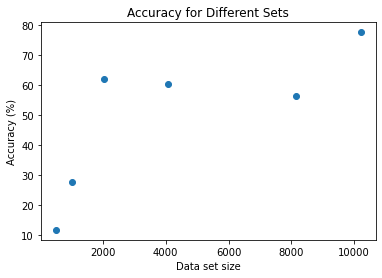

In [24]:
# Plot accuracy scatter plot
numbers = []

for string in sets:
    numeric_values = re.findall(r'\d+', string)
    numbers.extend([int(num) for num in numeric_values])

print(numbers)


# Create scatter plot
plt.scatter(numbers, accuracy)

# Set labels and title
plt.xlabel('Data set size')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy for Different Sets')

# Fix axis if needed
plt.xticks(rotation=0)  # Rotate the x-axis labels if needed

# Save the plot
plt.savefig('Accuracy per data set simple.jpeg', format='jpeg')

# Show the plot
plt.show()

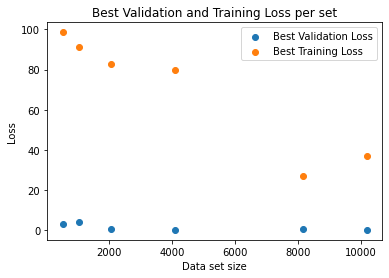

In [17]:
# Prepare data for scatter plot
y_val_losses = [best_val_losses[item] for item in sets]
y_train_losses = [best_train_losses[item] for item in sets]

# Create scatter plot
plt.scatter(numbers, y_val_losses, label='Best Validation Loss')
plt.scatter(numbers, y_train_losses, label='Best Training Loss')

# Set labels and title
plt.xlabel('Data set size')
plt.ylabel('Loss')
# plt.yscale('log')
plt.title('Best Validation and Training Loss per set')

# Add legend
plt.legend()

# Save the plot
plt.savefig('Best_losses_per_set simple.jpeg', format='jpeg')

# Show the plot
plt.show()

